In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all the words
imiona = open("imionapl.txt", encoding = "UTF-8").read().splitlines()
imiona = [i.lower() for i in imiona]
imiona[:5]

['ada', 'adalbert', 'adam', 'adela', 'adelajda']

In [ ]:
chars = sorted(list(set(''.join(imiona))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'y', 24: 'z', 25: 'ó', 26: 'ę', 27: 'ł', 28: 'ń', 29: 'ś', 30: 'ż', 0: '.'}
31


In [ ]:
# build the dataset
block_size = 3

def build_dataset(imiona):  
  X, Y = [], []
  
  for w in imiona:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(imiona)
n1 = int(0.8*len(imiona))
n2 = int(0.9*len(imiona))

Xtr,  Ytr  = build_dataset(imiona[:n1])     # 80%
Xdev, Ydev = build_dataset(imiona[n1:n2])   # 10%
Xte,  Yte  = build_dataset(imiona[n2:])     # 10%

torch.Size([3919, 3]) torch.Size([3919])
torch.Size([510, 3]) torch.Size([510])
torch.Size([480, 3]) torch.Size([480])


In [ ]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [ ]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(99) 
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1



parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [ ]:
batch_size = 32
n = batch_size 
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [ ]:
probs.shape

NameError: name 'probs' is not defined

In [ ]:
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1)
# Linear layer 1
hprebn = embcat @ W1 + b1 
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) 
# Linear layer 2
logits = h @ W2 + b2 
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.6366, grad_fn=<NegBackward0>)

In [ ]:
dlogprobs = torch.zeros(logprobs.shape)
dlogprobs[range(n), Yb] = -1./n
dprobs = 1./probs * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdims = True)
dcounts = counts_sum_inv * dprobs
dcounts_sum =  -counts_sum**(-2)  * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum 
dnorm_logits =  counts * dcounts
dlogits1 = dnorm_logits
dlogits2 = torch.zeros(logits.shape)
dlogits2[range(n),logits.argmax(1)] = 1
dlogit_maxes  = -dnorm_logits.sum(1, keepdims = True)
dlogits = dlogits1  + (dlogits2* dlogit_maxes)
dh = dlogits @ W2.T
dW2 =  h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdims = True) 
dbnraw = bngain * dhpreact
dbnbias = 1 * dhpreact.sum(0)
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdims = True)
dbndiff_1 = bnvar_inv * dbnraw
dbnvar= (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 =((1.0)/(n-1)*torch.ones_like(bndiff2))* dbnvar
dbndiff_2 = 2 * bndiff * dbndiff2
dbndiff = dbndiff_1 + dbndiff_2
dbnmeani = -torch.ones_like(bnmeani) * dbndiff.sum(0)
dhprebn_1 = dbndiff.clone() 
dhprebn_2 = 1.0/n*torch.ones_like(hprebn) * dbnmeani
dhprebn = dhprebn_1 + dhprebn_2
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[i,j]
        dC[ix] += demb[i,j]



cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)


logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [ ]:
# backprop through cross_entropy but all in one go

# forward pass
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())


# backward pass
#https://www.mldawn.com/the-derivative-of-softmaxz-function-w-r-t-z/

dlogits = F.softmax(logits,1)
dlogits[range(n), Yb] -= 1
dlogits /= n #mean
cmp('logits', dlogits, logits) 

3.636566162109375 diff: -2.384185791015625e-07
logits          | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


In [ ]:
F.softmax(logits, 1)[0]

tensor([0.0282, 0.0200, 0.0172, 0.0106, 0.0262, 0.0219, 0.0335, 0.0833, 0.0139,
        0.0461, 0.0233, 0.0189, 0.0341, 0.0593, 0.0695, 0.0177, 0.0365, 0.0158,
        0.0122, 0.0267, 0.0420, 0.0287, 0.0221, 0.0157, 0.0667, 0.0286, 0.0289,
        0.0787, 0.0156, 0.0172, 0.0408], grad_fn=<SelectBackward0>)

In [ ]:
dlogits[0] * n 

tensor([ 0.0282,  0.0200,  0.0172,  0.0106,  0.0262,  0.0219,  0.0335,  0.0833,
         0.0139,  0.0461,  0.0233,  0.0189,  0.0341,  0.0593,  0.0695,  0.0177,
         0.0365, -0.9842,  0.0122,  0.0267,  0.0420,  0.0287,  0.0221,  0.0157,
         0.0667,  0.0286,  0.0289,  0.0787,  0.0156,  0.0172,  0.0408],
       grad_fn=<MulBackward0>)

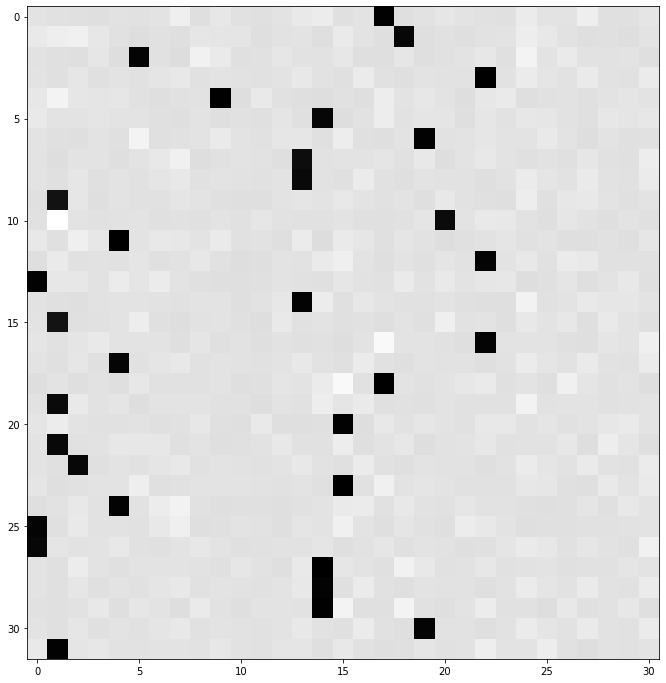

In [ ]:
plt.figure(figsize =( 12,12))
plt.imshow(dlogits.detach(), cmap = "gray")